In [1]:
import os, pathlib, random
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# img_root_dir = "/media/putto/DATA/CCPD/CCPD2019/" # R6
img_root_dir = "/home/putto/Playground/CCPD2019" # Mi
train_root = pathlib.Path(img_root_dir)

# 翻译文件名
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

In [2]:
class ImageInfo():
    """
    可用的值： 
    self.full_name
    self.h_tilt 
    self.v_tilt 这两个值似乎与 four_vertices_locations 计算出来的值不大相符
    self.bounding_box_coordinates 用于画外框，左上及右下坐标，黄色
    self.four_vertices_locations 用于描车牌的边，红色
    self.brightness
    self.blurriness
    """
    def __init__(self, dir):
        # 记录完整路径
        self.full_name = dir
        # 找出带有车牌信息的文件名(chaos_name)以及扩展名(extension_name)
        chaos_name, self.extension = dir.split(os.sep)[-1].split(".")
        # 解析 chaos_name
        [area_ratio, tilt_degree, bounding_box_coordinates, 
         four_vertices_locations, license_plate_number, 
         brightness, blurriness] = chaos_name.split("-")
        # area_ratio 是车牌面积比率，2-4位数，暂时不知道咋解析
        # tilt 是倾斜角度，但是好像区分不了方向啊？
        self.h_tilt, self.v_tilt = [int(x) for x in tilt_degree.split("_")]
        # bounding_box_coordinates 包含四个坐标
        coordinates_str_array = bounding_box_coordinates.split("_")
        self.bounding_box_coordinates = []
        for xy_str in coordinates_str_array:
            x_str, y_str = xy_str.split("&")
            self.bounding_box_coordinates.append((int(x_str), int(y_str)))
        # four_vertices_locations 四个顶点的位置
        four_vertices_locations_str_array = four_vertices_locations.split("_")
        self.four_vertices_locations = []
        for xy_str in four_vertices_locations_str_array:
            x_str, y_str = xy_str.split("&")
            self.four_vertices_locations.append((int(x_str), int(y_str)))
        # 解析车牌号
        license_plate_number_str_array = license_plate_number.split("_")
        lpna = [int(x) for x in license_plate_number_str_array]
        self.license_plate_number = provinces[lpna[0]] + alphabets[lpna[1]]
        for i in lpna[2:]:
            self.license_plate_number += ads[i]
        # 最后是 亮度 和 模糊度
        self.brightness, self.blurriness = int(brightness), int(blurriness)
    def split_chaos_name(self):
        scn = self.chaos_name.split("&")
        assert len(scn) == 7
        self.license_plate_number_str = scn[6]
        self.left_bottom_str = scn[4]
        self.right_top_str = scn[5]

/home/putto/Playground/CCPD2019
/home/putto/Playground/CCPD2019/ccpd_base/025-0_2-357&490_597&577-597&577_360&574_357&490_594&493-0_0_6_31_10_32_26-130-112.jpg: [皖AG7L82]


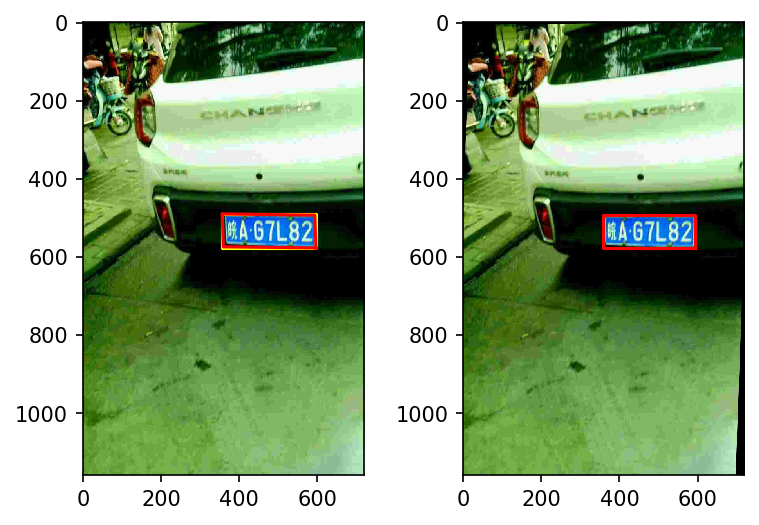

In [3]:
plt.figure(dpi=150)
env_names = []

print(train_root)
all_image_paths = list(train_root.glob('*/*'))
all_image_paths = [str(item) for item in all_image_paths]


lucky_filename = random.choice(all_image_paths)

sample = ImageInfo(lucky_filename)
print(sample.full_name + ": [" + sample.license_plate_number + "]")

# 显示图片
img = cv2.imread(sample.full_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(img)

# 画出车牌外框 bounding_box
[(a,b),(c,d)] = sample.bounding_box_coordinates
plt.plot([a, c, c, a, a], [b, b, d, d, b], color="yellow")

# 画出车牌四个顶点 four_vertices_locations
[(a,b),(c,d),(e,f),(g,h)] = sample.four_vertices_locations
plt.plot([a, c, e, g, a], [b, d, f, h, b], color="red")

plt.subplot(1,2,2)
# 将车牌扭成“正面"的
rows, cols, _ = img.shape
[(a,b),(c,d),(e,f),(g,h)] = sample.four_vertices_locations
pts1 = np.float32([[a,b], [c,d], [e,f]])
x = min(c, e)
pts2 = np.float32([[g,b], [x,b], [x,h]])
M = cv2.getAffineTransform(pts1, pts2)
dst = cv2.warpAffine(img, M, (cols, rows))
plt.imshow(dst)
# 描边
plt.plot([g, x, x, g, g], [b, b, h, h, b], color="red")
plt.show()

In [6]:
# 打乱顺序，生成 dataset。格式参考 yymnist_train.txt
# /home/putto/Playground/TensorFlow2.0-Examples/4-Object_Detection/YOLOV3/data/dataset/test/000140.jpg 46,322,130,406,3 327,209,411,293,9

# 搞乱
random.shuffle(all_image_paths)
# 写入文件
with open("/home/putto/Playground/lpsw_train.txt", "w") as train_file:
    for path in all_image_paths[:-10000]:
        try:
            sample = ImageInfo(path)
            [(a,b),(c,d)] = sample.bounding_box_coordinates
            train_file.write("%s %d,%d,%d,%d,0\n" % (path, a, b, c, d))
        except:
            pass # 忽略掉格式不正确的文件
with open("/home/putto/Playground/lpsw_test.txt", "w") as train_file:
    for path in all_image_paths[-10000:]:
        try:
            sample = ImageInfo(path)
            [(a,b),(c,d)] = sample.bounding_box_coordinates
            train_file.write("%s %d,%d,%d,%d,0\n" % (path, a, b, c, d))
        except:
            pass # 忽略掉格式不正确的文件